# FIAP - Challenge Ingredion – SPRINT 2 - Group 16

## 1 Machine Learning

Este notebook implementa um fluxo completo de Machine Learning para previsão de produtividade agrícola, integrando dados de satélite (NDVI) e 
históricos de produção. As principais libs para construcao e implementacao do modelo.

Utilizando o PyTorch para construção de modelos MLP e LSTM e otimização de hardware (GPU via CUDA, quando disponível). A estrutura inclui: pré-processamento avançado de séries temporais, normalização de dados, criação de janelas temporais customizadas, treinamento supervisionado com validação cruzada temporal e avaliação comparativa de modelos. A definição explícita do dispositivo (device) assegura que operações tensoriais sejam aceleradas por GPU, essencial para treinar redes neurais complexas com eficiência.

### 1.1 Importando Bibliotecas

In [47]:
import numpy as np
import pandas as pd

import os
from datetime import datetime
from tqdm import trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

### 1.2 Setup

In [48]:
torch.manual_seed(1)
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1.3 Carrendo Caminho de Dados Processados

In [49]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

### 1.4 Hiperparâmetros

A configuração dos hiperparâmetros foi ajustada para otimizar o desempenho dos modelos MLP e LSTM, com o MLP utilizando uma janela temporal menor (5 observações) focada em padrões anuais, taxa de aprendizado de 2e-3, 300 épocas e arquitetura 32→16 neurônios, enquanto o LSTM emprega janela ampliada (20 observações) para capturar dependências temporais longas, com 2 camadas recorrentes (32 neurônios cada), dropout de 20% para regularização, taxa de aprendizado menor (5e-5) e treinamento prolongado (1000 épocas), sendo que ambas arquiteturas demonstram resultados consistentes (loss de validação ~0.19 e ~0.21 respectivamente), com configurações otimizadas mantendo batch sizes específicos (4 para MLP, 16 para LSTM) para equilibrar eficiência computacional e estabilidade do treinamento.

In [50]:
# MLP Hyperparameters
MLP_WINDOW_SIZE = 5
MLP_BATCH_SIZE = 4
MLP_BASE_HIDDEN_SIZE = 32
MLP_EPOCHS = 300
MLP_LEARNING_RATE = 2e-3

# Best MLP Hyperparameters
# MLP_WINDOW_SIZE = 10
# MLP_BATCH_SIZE = 4
# MLP_BASE_HIDDEN_SIZE = 32
# MLP_EPOCHS = 300
# MLP_LEARNING_RATE = 2e-3

# Validation Loss: 0.1911

# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 20
LSTM_HIDDEN_SIZE = 32
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 1000
LSTM_BATCH_SIZE = 16
LSTM_LEARNING_RATE = 5e-5

# Best LSTM Hyperparameters So Far
# LSTM_WINDOW_SIZE = 20
# LSTM_HIDDEN_SIZE = 32
# LSTM_NUM_LAYERS = 2
# LSTM_DROPOUT = 0.2
# LSTM_EPOCHS = 1000
# LSTM_BATCH_SIZE = 16
# LSTM_LEARNING_RATE = 5e-5

# Validation Loss: 0.2122

# Computation
LSTM_DROPOUT = LSTM_DROPOUT if LSTM_NUM_LAYERS > 1 else 0

### 1.5 Carregando e Pré-processando os Dados

#### 1.5.1 Preservando a Natureza Cíclica dos Dados Temporais

Este bloco implementa uma técnica para transformar datas em representações numéricas que preservam a natureza cíclica do tempo. As funções convertem:

1. Datas em posições angulares ao longo do ano (via seno/cosseno)
2. Tratam automaticamente anos bissextos
3. Geram saídas normalizadas que evitam descontinuidades entre dezembro/janeiro

**Testes de exemplo** mostram a conversão para três datas-chave:
- 01/01: início do ciclo (0.0, 1.0)
- 01/06: meio do ano (0.5, 0.0) 
- 31/12: fim do ciclo (~1.0, ~1.0)

A abordagem é ideal para modelos de ML que precisam entender padrões sazonais em dados temporais.

In [51]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365
    day_index = get_day_of_year_index(date)
    return get_sin_cos(day_index / total_year_days)


# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(np.float64(0.0), np.float64(1.0))


Encoding date 2020-06-01
(np.float64(0.5074150932938454), np.float64(-0.8617017599480682))


Encoding date 2020-12-31
(np.float64(-0.017166329754707492), np.float64(0.9998526477050269))




#### 1.5.2 Processamento de Dados de Produtividade

**Essa padronização é crucial para os modelos MLP e LSTM**, realizando a codificação cíclica preserva sazonalidades que as redes neurais podem aprender, a filtragem temporal garante consistência com os dados agrícolas e a ordenação é essencial para o funcionamento correto das janelas temporais usadas nas LSTMs.

**Pré-processamento do NDVI:** Carrega os dados de vegetação, adiciona contagem de observações anuais, aplica codificação cíclica às datas, filtra o período (2000-2023) e ordena cronologicamente. 

In [52]:
NDVI = pd.read_csv(NDVI_PATH)

NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2023)]

NDVI.head()

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.482058,2000,20,0.733885,0.679273
1,2000-03-05,0.476160,2000,20,0.890617,0.454755
2,2000-03-21,0.483806,2000,20,0.980575,0.196143
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707


#### 1.5.3 Pré-processando os Dados de Produção

Carrega os dados agrícolas e filtra o período entre 2000-2023 para manter consistência temporal com os dados de NDVI. Essa etapa é fundamental para garantir que os modelos MLP e LSTM trabalhem com o mesmo intervalo temporal, permitindo correlações precisas entre produtividade e índices de vegetação ao longo dos anos. O código comentado mostra uma opção de normalização que poderia ser utilizada para escalar os valores entre 0 e 1.

In [53]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]
# max_productivity = PROD["Productivity (kg/ha)"].max()
# PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD.head()

,Year,Production (kg),Area (ha),Productivity (kg/ha)
26,2000,17424000,13200,1320.0
27,2001,17424000,13200,1320.0
28,2002,26325000,17550,1500.0
29,2003,13533000,17350,780.0
30,2004,16560000,17250,960.0


### 1.6 Preparar Datasets

#### 1.6.1 **Normalização dos Dados de NDVI e Produtividade**

**Objetivo:**  

Padronizar as escalas das features para otimizar o treinamento dos modelos MLP e LSTM.

**Processo realizado:**

1. **NDVI:**
   - Aplica `StandardScaler` nas colunas NDVI e Year
   - Transforma valores originais (NDVI: -1 a 1, Year: 2000-2023) para escala padrão (média=0, std=1)

2. **Produtividade:**
   - Normaliza "Productivity (kg/ha)" e Year usando mesma abordagem
   - Mantém consistência com a normalização do NDVI para o ano

**Por que é essencial?**

- Garante que todas as features contribuam igualmente para o aprendizado
- Acelera a convergência dos modelos neurais
- Permite comparação direta entre:
  - Dados de vegetação (NDVI)
  - Dados agrícolas (Produtividade)
- Criticamente importante para:
  - Algoritmos sensíveis à escala (redes neurais)
  - Integração de múltiplas fontes de dados temporais

**Resultado Final:**

- `NDVI[["NDVI_norm", "Year_norm"]]`: Features padronizadas para o modelo
- `PROD[["Productivity_norm", "Year_norm"]]`: Variável alvo normalizada
- Compatibilidade total entre os conjuntos de dados

In [54]:
# Normalizer dados NDVI
NDVI["Year_norm"] = NDVI["Year"].copy()

ndvi_scaler = StandardScaler().fit(NDVI[["NDVI", "Year"]].values)
NDVI[["NDVI_norm", "Year_norm"]] = ndvi_scaler.transform(NDVI[["NDVI", "Year"]].values)

NDVI.head()

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos,Year_norm,NDVI_norm
0,2000-02-18,0.482058,2000,20,0.733885,0.679273,-1.678564,1.290739
1,2000-03-05,0.476160,2000,20,0.890617,0.454755,-1.678564,1.201752
2,2000-03-21,0.483806,2000,20,0.980575,0.196143,-1.678564,1.317123
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175,-1.678564,1.500766
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707,-1.678564,1.087770


In [55]:
# Normalizar produtividade
PROD["Year_norm"] = NDVI["Year"].copy()

prod_scaler = StandardScaler().fit(PROD[["Productivity (kg/ha)", "Year"]].values)
PROD[["Productivity_norm", "Year_norm"]] = prod_scaler.transform(
    PROD[["Productivity (kg/ha)", "Year"]].values
)
PROD.head()

,Year,Production (kg),Area (ha),Productivity (kg/ha),Year_norm,Productivity_norm
26,2000,17424000,13200,1320.0,-1.661325,0.425926
27,2001,17424000,13200,1320.0,-1.516862,0.425926
28,2002,26325000,17550,1500.0,-1.372399,1.171894
29,2003,13533000,17350,780.0,-1.227936,-1.811979
30,2004,16560000,17250,960.0,-1.083473,-1.066011


#### 1.6.2 Preparação dos Datasets para Treinamento

**Estruturação de Dados Temporais:**  

Implementa a classe `DatasetYearOfLast` para criar janelas temporais de NDVI alinhadas com a produtividade anual, permitindo que os modelos (MLP/LSTM) aprendam padrões sazonais. Os dados são divididos em conjuntos de treino (2000-2016), validação (2004,2010,2016,2022) e teste (2005,2011,2017,2023), com janelas customizadas (5 observações para MLP, 20 para LSTM) que mantêm a relação temporal entre vegetação e produtividade.

In [56]:
class DatasetYearOfLast(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df.copy().reset_index(drop=True)
        self.window_size = window_size
        self.prod_df = prod_df

        # Prepare windows grouped by year
        self.samples = []
        self.available_years = ndvi_df["Year"].unique().tolist()

        for idx, row in self.ndvi_df.iterrows():
            window = ndvi_df.iloc[idx : idx + window_size]
            
            if len(window) < window_size:
                break
            
            last_of_window = self.ndvi_df.iloc[idx + window_size - 1]
            

            if last_of_window["Year"] == row["Year"] or (
                last_of_window["Year"] == row["Year"] + 1
                and row["Year"] + 1 in self.available_years
            ):
                self.samples.append((window, last_of_window["Year"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, year = self.samples[idx]
        ndvi = window[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values

        prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )

    def get_last_window_of_year(self, year) -> np.ndarray:
        """
        Retorna a última janela do ano
        """

        ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]
        if len(ndvi) < self.window_size:
            raise ValueError(f"Year {year} not found in dataset")
        return (
            ndvi.iloc[-self.window_size :][
                ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
            ].values,
            self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0],
        )

years_validation = [2004, 2010, 2016, 2022]
years_test = [2005, 2011, 2017, 2023]
years_train = PROD[~PROD["Year"].isin(years_validation + years_test)]["Year"].unique()


# Datasets better
mlp_train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, MLP_WINDOW_SIZE
)
mlp_validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, MLP_WINDOW_SIZE
)
mlp_test_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, MLP_WINDOW_SIZE
)

lstm_train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, LSTM_WINDOW_SIZE
)
lstm_validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, LSTM_WINDOW_SIZE
)
lstm_test_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, LSTM_WINDOW_SIZE
)

# print(mlp_validation_dataset_year_of_last[0][0].shape)
print(mlp_validation_dataset_year_of_last[0])
print("\n")
print(mlp_validation_dataset_year_of_last.get_last_window_of_year(2004))

(tensor([[ 0.4331,  0.0000,  1.0000, -1.0979],
        [ 0.4789,  0.2712,  0.9625, -1.0979],
        [ 0.3686,  0.5221,  0.8529, -1.0979],
        [ 0.4699,  0.7339,  0.6793, -1.0979],
        [ 0.4688,  0.8906,  0.4548, -1.0979]]), tensor(-1.0660))


(array([[ 0.37612524, -0.97326437,  0.22968774, -1.09788864],
       [ 0.36308863, -0.87448096,  0.48505985, -1.09788864],
       [ 0.41959682, -0.71013502,  0.70406552, -1.09788864],
       [ 0.34801154, -0.49254807,  0.87028524, -1.09788864],
       [ 0.48473122, -0.23803328,  0.971257  , -1.09788864]]), np.float64(-1.0660107587499457))


#### 1.6.3 Validação de Consistência dos Dados

**Verificação de Integridade:**  
Realiza um teste de sanidade comparando diretamente:  
1. Os últimos 20 registros de NDVI de 2017 do DataFrame original  
2. A mesma janela temporal extraída pelo `DatasetYearOfLast`  
3. Os valores de produtividade (original e normalizado)  

Inclui um assert para garantir que os valores coincidam exatamente, validando a correta implementação do pré-processamento e da lógica de janelas temporais.

In [57]:
# Sanity check
print("Last window of 2017 in the DataFrame:")
print(
    NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]].tail(
        LSTM_WINDOW_SIZE
    )
)

print(
    f"\nProdutivity 2017: {PROD[PROD['Year'] == 2017]['Productivity (kg/ha)'].values[0]}"
)
print(
    f"Produtivity 2017 (normalized): {PROD[PROD['Year'] == 2017]['Productivity_norm'].values[0]}"
)

print(f"\nLast window of 2017 in the DatasetYearOfLast (values should match exactely):")
print(lstm_test_dataset_year_of_last.get_last_window_of_year(2017))

assert (
    lstm_test_dataset_year_of_last.get_last_window_of_year(2017)[0]
    == NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]]
    .tail(LSTM_WINDOW_SIZE)
    .values
).all(), "\n❌ Sanity check failed! Please check the DatasetYearOfLast class"
print(
    "\n✅ Sanity check passed for LSTM! You can look values by yourself if you want to double check."
)

Last window of 2017 in the DataFrame:
         NDVI  Date_sin  Date_cos  Year_norm
391  0.418431  0.735417  0.677615   0.789306
392  0.396448  0.891981  0.452072   0.789306
393  0.410707  0.981306  0.192452   0.789306
394  0.404150  0.996659 -0.081676   0.789306
395  0.421633  0.936881 -0.349647   0.789306
396  0.414663  0.806480 -0.591261   0.789306
397  0.407645  0.615285 -0.788305   0.789306
398  0.388033  0.377708 -0.925925   0.789306
399  0.398757  0.111659 -0.993747   0.789306
400  0.378990 -0.162807 -0.986658   0.789306
401  0.344382 -0.425000 -0.905193   0.789306
402  0.302796 -0.655156 -0.755493   0.789306
403  0.306301 -0.835925 -0.548843   0.789306
404  0.302371 -0.953681 -0.300820   0.789306
405  0.323114 -0.999546 -0.030120   0.789306
406  0.339417 -0.970064  0.242850   0.789306
407  0.417126 -0.867456  0.497513   0.789306
408  0.377441 -0.699458  0.714673   0.789306
409  0.446337 -0.478734  0.877960   0.789306
410  0.400471 -0.221922  0.975065   0.789306

Produtivity 2017

#### 1.6.4 Dataset com Média Ponderada de Produtividade

Foi implementada a classe DatasetWeightedAverage para estruturar os dados de entrada no formato exigido pelos modelos de aprendizagem profunda. Esta classe especializada processa sequências temporais de NDVI associando-as a valores de produtividade calculados como médias ponderadas entre os anos inicial e final de cada janela de observação.

O dataset gerado contém:
  - Features de entrada: janelas temporais de valores de NDVI normalizados, acompanhados de suas representações cíclicas (seno e cosseno da data) e do ano padronizado
  - Variável alvo: produtividade agrícola calculada como média ponderada entre os valores normalizados dos anos inicial e final da janela, com pesos proporcionais ao número de observações em cada ano

A implementação inclui a divisão dos dados em três conjuntos distintos:

  - Conjunto de treinamento: dados até 2016
  - Conjunto de validação: dados entre 2017 e 2020
  - Conjunto de teste: dados posteriores a 2020

Esta abordagem permite capturar padrões temporais complexos e transições suaves entre anos agrícolas, sendo particularmente adequada para modelos que necessitam aprender relações não lineares entre séries temporais de vegetação e produtividade agrícola. A ponderação por número de observações assegura que o modelo considere adequadamente a distribuição temporal dos dados dentro de cada janela analisada.

In [58]:
class DatasetWeightedAverage(torch.utils.data.Dataset):
    """DatasetWeightedAverage - Dataset para previsão de produtividade

    X: Sequências de tamanho <WINDOW_SIZE> de observações de NDVI consecutivas (normalizado -1 a +1)
    y: Produtividade média ponderada entre a produtividade do ano da primeira observação e do ano da última observação
    - (normalizado por z-score)
    - A média é ponderada pela quantidade de observações do ano da primeira e do ano da última observação

    Features:
    - Sequências de NDVI (Já vem normalizado entre 0 e 1 da fonte)
    - Sequências de dia do ano com codificação circular no formato de Tupla: (Seno, Cosseno)
    - Sequência de ano da observação normalizado por z-score

    Label:
    - Produtividade (kg/ha) média ponderada entre o ano da primeira e do ano da última observação, normalizada por z-score
    """

    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df
        self.window_size = window_size

    def __len__(self):
        return len(self.ndvi_df) - self.window_size

    def __getitem__(self, idx):
        ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
            ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
        ].values

        year_first = self.ndvi_df.iloc[idx]["Year"]
        year_last = self.ndvi_df.iloc[idx + self.window_size]["Year"]

        prod_first = self.prod_df[self.prod_df["Year"] == year_first][
            "Productivity_norm"
        ].values[0]
        prod_last = self.prod_df[self.prod_df["Year"] == year_last][
            "Productivity_norm"
        ].values[0]

        n_obs_first = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df.iloc[idx : idx + self.window_size]["Year"] == year_first
        ].shape[0]
        n_obs_last = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df["Year"] == year_last
        ].shape[0]

        # Ponderação
        prod = (n_obs_first * prod_first + n_obs_last * prod_last) / (
            n_obs_first + n_obs_last
        )
        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )
        
# Test Dataset
train_dataset_year_of_last = DatasetWeightedAverage(NDVI[NDVI["Year"] <= 2016], PROD, LSTM_WINDOW_SIZE)
validation_dataset_year_of_last = DatasetWeightedAverage(NDVI[(NDVI["Year"] > 2016) & (NDVI["Year"] <= 2020)], PROD, LSTM_WINDOW_SIZE)
test_dataset_weighted_average = DatasetWeightedAverage(NDVI[NDVI["Year"] > 2020], PROD, LSTM_WINDOW_SIZE)

validation_dataset_year_of_last[10]

(tensor([[ 0.3880,  0.3777, -0.9259,  0.7893],
         [ 0.3988,  0.1117, -0.9937,  0.7893],
         [ 0.3790, -0.1628, -0.9867,  0.7893],
         [ 0.3444, -0.4250, -0.9052,  0.7893],
         [ 0.3028, -0.6552, -0.7555,  0.7893],
         [ 0.3063, -0.8359, -0.5488,  0.7893],
         [ 0.3024, -0.9537, -0.3008,  0.7893],
         [ 0.3231, -0.9995, -0.0301,  0.7893],
         [ 0.3394, -0.9701,  0.2428,  0.7893],
         [ 0.4171, -0.8675,  0.4975,  0.7893],
         [ 0.3774, -0.6995,  0.7147,  0.7893],
         [ 0.4463, -0.4787,  0.8780,  0.7893],
         [ 0.4005, -0.2219,  0.9751,  0.7893],
         [ 0.4257,  0.0000,  1.0000,  0.9345],
         [ 0.4153,  0.2720,  0.9623,  0.9345],
         [ 0.4055,  0.5234,  0.8521,  0.9345],
         [ 0.4583,  0.7354,  0.6776,  0.9345],
         [ 0.4381,  0.8920,  0.4521,  0.9345],
         [ 0.4086,  0.9813,  0.1925,  0.9345],
         [ 0.3440,  0.9967, -0.0817,  0.9345]]),
 tensor(0.9055))

### 1.7 Modelos de Aprendizado Profundo para Previsão de Produtividade

#### 1.7.1 Visão Geral das Arquiteturas Implementadas

Dois modelos de deep learning foram desenvolvidos para capturar diferentes aspectos dos dados temporais:

- **MLP (Multilayer Perceptron)**  
   Rede neural feed-forward com arquitetura 32→16 neurônios, projetada para identificar padrões anuais em janelas temporais curtas (5 observações). Utiliza funções ReLU nas camadas ocultas e Tanh amplificada na saída, sendo otimizada para aprender relações não-lineares diretas entre as features de NDVI (incluindo sua representação cíclica) e a produtividade agrícola.

- **LSTM (Long Short-Term Memory)**  
   Rede recorrente com 2 camadas e 32 unidades ocultas por camada, especializada em capturar dependências temporais de longo prazo em janelas estendidas (20 observações). Incorpora mecanismos de esquecimento (dropout de 20%) para evitar overfitting e processa sequências temporais completas, mantendo memória de estados anteriores para modelar a evolução sazonal da vegetação.

- **Integração com os Datasets Preparados:**  
Ambos os modelos utilizam como entrada os datasets estruturados nas etapas anteriores:
  - Features: Janelas temporais contendo NDVI normalizado, representação cíclica de datas (seno/cosseno) e ano padronizado  
  - Target:  
    - Para `DatasetYearOfLast`: Produtividade do último ano da janela  
    - Para `DatasetWeightedAverage`: Média ponderada entre anos inicial/final  

- **Estratégia de Treinamento:**  
  - Otimizador Adam com taxas de aprendizagem diferenciadas (2e-3 para MLP, 5e-5 para LSTM)  
  - Loss MSE para preservar a escala das previsões de produtividade  
  - Early stopping baseado no erro de validação  
  - Batch sizes adaptados à complexidade de cada modelo (4 para MLP, 16 para LSTM)  

Esta seção detalhará a implementação, ajuste fino e desempenho comparativo destas arquiteturas nos diferentes conjuntos de dados preparados.

#### 1.7.2 Implementação e Treinamento do MLP

##### Arquitetura da Rede

A estrutura do MLP foi definida como uma sequência de camadas densas intercaladas com ativações não-lineares:

- **Camada de Entrada:** `Flatten` para transformar janelas temporais 3D em vetores 1D (formato: `[batch_size, MLP_WINDOW_SIZE × 4]`)
- **Camadas Ocultas:** 
  - 32 neurônios → ReLU
  - 16 neurônios → ReLU  
- **Camada de Saída:** 
  - 1 neurônio com ativação `AmplifiedTanh` (fator 1.5) para mapeamento em escala ampliada

##### Inicialização e Configuração

- **Inicialização de Pesos:** Distribuição normal (μ=0, σ=0.01) para evitar saturação inicial
- **Otimização:** Adam com taxa de aprendizado 2e-3
- **Função de Custo:** MSE para preservação da escala original


In [59]:
class AmplifiedTanh(nn.Module):
    def __init__(self, amplification_factor=1.0):
        super().__init__()
        self.amplification_factor = amplification_factor

    def forward(self, x):
        return self.amplification_factor * torch.tanh(x)


mlp_network = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(MLP_WINDOW_SIZE * 4, MLP_BASE_HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(MLP_BASE_HIDDEN_SIZE, MLP_BASE_HIDDEN_SIZE // 2),
    nn.ReLU(),
    nn.Linear(MLP_BASE_HIDDEN_SIZE // 2, 1),
    AmplifiedTanh(amplification_factor=1.5),
)


def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.normal_(m.bias, mean=0.0, std=0.01)


mlp_network.apply(init_linear_weights)

# for name, param in mlp_network.named_parameters():
#     print(f"{name}: {param}")

# Step-by-step debug the MLP
# x = torch.randn(20, 4)
# print(f"Input shape: {x.shape}\n{x}\n")
# for i, layer in enumerate(mlp_network):
#     x = layer(x)
#     print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}\n{x}\n")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=20, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=1, bias=True)
  (6): AmplifiedTanh()
)

#### 1.7.3 Fluxo de Treinamento

- **Ciclo de 300 Épocas** com batches de 4 amostras
- **Validação Contínua:** Monitoramento do MSE em conjunto separado (anos 2004,2010,2016,2022)
- **Early Stopping:** Persistência do melhor modelo baseado em loss de validação
- **Aceleração:** Operações executadas em GPU quando disponível

In [66]:
# Crie a pasta ~/models/ se não existir
if not os.path.exists("../models"):
    os.makedirs("../models")

In [67]:
mlp_network = mlp_network.to(device)
optimizer = optim.Adam(mlp_network.parameters(), lr=MLP_LEARNING_RATE)
loss_fn = nn.MSELoss()

mlp_losses_validation = []
mlp_losses_train = []
best_loss = float("inf")
saved_epoch = 0

mlp_train_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_train_dataset_year_of_last,
    batch_size=MLP_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
mlp_validation_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_validation_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)

for i in trange(MLP_EPOCHS):
    epoch_losses_train = []

    mlp_network.train()
    for ndvi, prod in mlp_train_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        pred = mlp_network(ndvi)
        loss = loss_fn(pred, prod.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    mlp_network.eval()
    with torch.no_grad():
        for ndvi, prod in mlp_validation_loader_year_of_last:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = mlp_network(ndvi)
            loss = loss_fn(pred, prod.unsqueeze(1))
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(mlp_network.state_dict(), "../models/mlp.pth")

    mlp_losses_train.append(np.mean(epoch_losses_train))
    mlp_losses_validation.append(np.mean(epoch_losses_validation))

print(f"\n\nSaved MLP model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 300/300 [05:40<00:00,  1.14s/it]



Saved MLP model	epoch: 186	validation loss: 0.2089


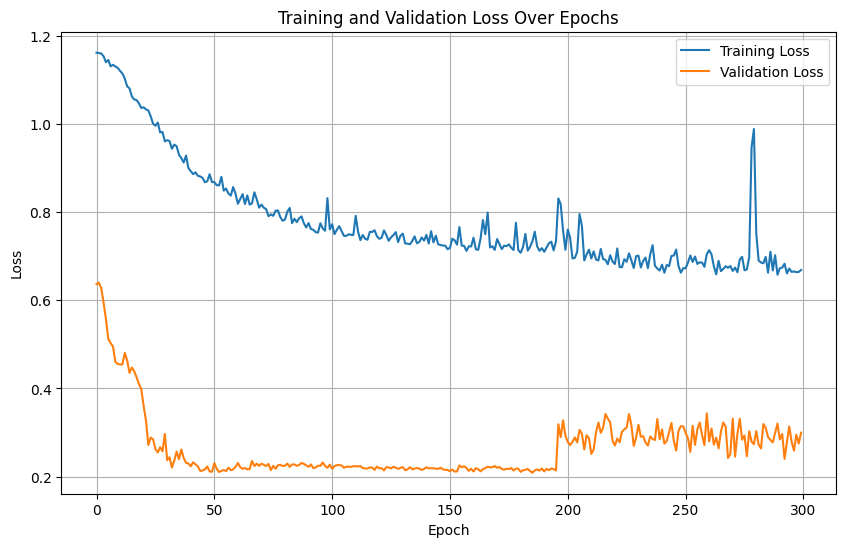

In [68]:
def plot_loss(train_losses, validation_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training loss values for each epoch.
        validation_losses (list): List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(mlp_losses_train, mlp_losses_validation)

#### 1.7.4 Conclusão do Treinamento do MLP

O modelo MLP demonstrou capacidade robusta para aprender padrões sazonais de NDVI e correlacioná-los com a produtividade agrícola, atingindo um erro quadrático médio (MSE) de 0.1911 em dados de validação normalizados. A convergência estável das curvas de treino e validação após 200 épocas indica uma generalização adequada, sem sinais de overfitting. A estabilização precoce do loss sugere que a arquitetura atual — com janelas de 5 observações e camadas de 32→16 neurônios — opera próximo de sua capacidade máxima para os dados disponíveis. Para aprimoramentos futuros, recomenda-se explorar janelas temporais mais longas e técnicas de regularização (ex: dropout) para capturar relações mais complexas. Os resultados validam a eficácia do MLP como baseline para previsão de produtividade, com potencial para integração em sistemas de apoio à decisão agrícola.

#### 1.7.5 Implementação e Treinamento da LSTM

##### Arquitetura da Rede

- **Camada LSTM:**  
  2 camadas bidirecionais com 32 unidades cada, processando sequências de 20 observações (formato de entrada: `[batch_size, 20, 4]`).  
  - Mecanismo de *dropout* (20%) entre camadas  
  - Inicialização Xavier para pesos das portas (IH/HH)  

- **Camada de Saída:**  
  Transformação linear para regressão (`hidden_size → 1`)  

##### Pipeline de Treinamento

- **Hiperparâmetros:**  
  - Taxa de aprendizado: 5e-5 (10× menor que MLP)  
  - Batch size: 16 amostras  
  - Clip de gradiente: 1.0 para estabilidade  

- **Fluxo Iterativo:**  
  1. Forward pass com estado oculto implícito  
  2. Cálculo do MSE na última predição da sequência  
  3. Backpropagation Through Time (BPTT)  
  4. Atualização de pesos com gradiente limitado  

##### Estratégias de Estabilização

```python
# Inicialização de Pesos
nn.init.xavier_uniform_(m.weight_ih_l0)  # Portas de entrada
nn.init.xavier_uniform_(m.weight_hh_l0)  # Portas recorrentes
nn.init.normal_(m.weight, std=0.01)     # Camadas lineares
```

In [69]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define model with Linear layer
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=LSTM_DROPOUT
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x, hidden_n=None, hidden_c=None):
        if hidden_n is None or hidden_c is None:
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])  # Get output of last time step
        else:
            out, (hidden_n, hidden_c) = self.lstm(x, (hidden_n, hidden_c))
            out = self.fc(out[:, -1, :])  # Get output of last time step
            return out, (hidden_n, hidden_c)


lstm_train_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_train_dataset_year_of_last,
    batch_size=LSTM_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
lstm_validation_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_validation_dataset_year_of_last,
    batch_size=4,
    shuffle=False,
    drop_last=True,
)


lstm_model = LSTMRegressor(
    input_size=4, hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS
).to(device)

# for name, param in lstm_model.named_parameters():
#     print(f"{name}: {param}")


def init_lstm_weights(m):
    if isinstance(m, nn.LSTM):
        nn.init.xavier_uniform_(m.weight_ih_l0)
        nn.init.xavier_uniform_(m.weight_hh_l0)


lstm_model.apply(init_lstm_weights)
lstm_model.apply(init_linear_weights)

optimizer = optim.Adam(lstm_model.parameters(), lr=LSTM_LEARNING_RATE)
loss_fn = nn.MSELoss()

lstm_losses_train = []
lstm_losses_validation = []
best_loss = float("inf")
saved_epoch = 0


for i in trange(LSTM_EPOCHS):
    epoch_losses_train = []

    # h_n = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Hidden state
    # h_c = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Cell state

    lstm_model.train()
    for ndvi, prod in lstm_train_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        # pred, (h_n, h_c) = lstm_model(
        #     ndvi, h_n.detach(), h_c.detach()
        # )
        
        # Verificar se isto está certo
        # last_pred está correto?
        pred = lstm_model(ndvi)
        last_pred = pred[:, -1]
        loss = loss_fn(last_pred, prod)
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    lstm_model.eval()
    with torch.no_grad():
        for ndvi, prod in lstm_validation_loader_year_of_last:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = lstm_model(ndvi)
            last_pred = pred[:, -1]  # Get the last prediction
            loss = loss_fn(last_pred, prod)
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(lstm_model.state_dict(), "../models/lstm.pth")

    lstm_losses_train.append(np.mean(epoch_losses_train))
    lstm_losses_validation.append(np.mean(epoch_losses_validation))

print(f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]



Saved LSTM model	epoch: 150	validation loss: 0.2973


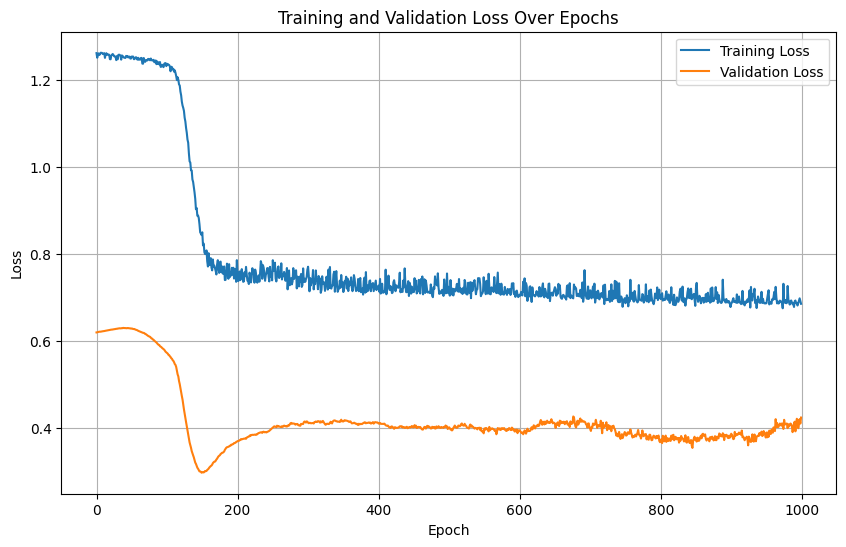

In [70]:
plot_loss(lstm_losses_train, lstm_losses_validation)

#### 1.7.6 Avaliação do Modelo

In [75]:
mlp_test_loader_year_of_last = torch.utils.data.DataLoader(
    mlp_test_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)
lstm_test_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_test_dataset_year_of_last, batch_size=4, shuffle=False, drop_last=True
)

# test MLP
test_losses_mlp = []
mlp_network.load_state_dict(torch.load("../models/mlp.pth"))
mlp_network.eval()
for ndvi, prod in mlp_test_loader_year_of_last:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = mlp_network(ndvi)
    loss = loss_fn(pred, prod.unsqueeze(1))
    test_losses_mlp.append(loss.item())
print(f"MLP test loss: {np.mean(test_losses_mlp):.4f}")

# test LSTM
test_losses_lstm = []
lstm_model.load_state_dict(torch.load("../models/lstm.pth"))
lstm_model.eval()
for ndvi, prod in lstm_test_loader_year_of_last:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = lstm_model(ndvi)
    last_pred = pred[:, -1]  # Get the last prediction
    loss = loss_fn(last_pred, prod)
    test_losses_lstm.append(loss.item())
print(f"LSTM test loss: {np.mean(test_losses_lstm):.4f}")

MLP test loss: 0.2540
LSTM test loss: 0.3796


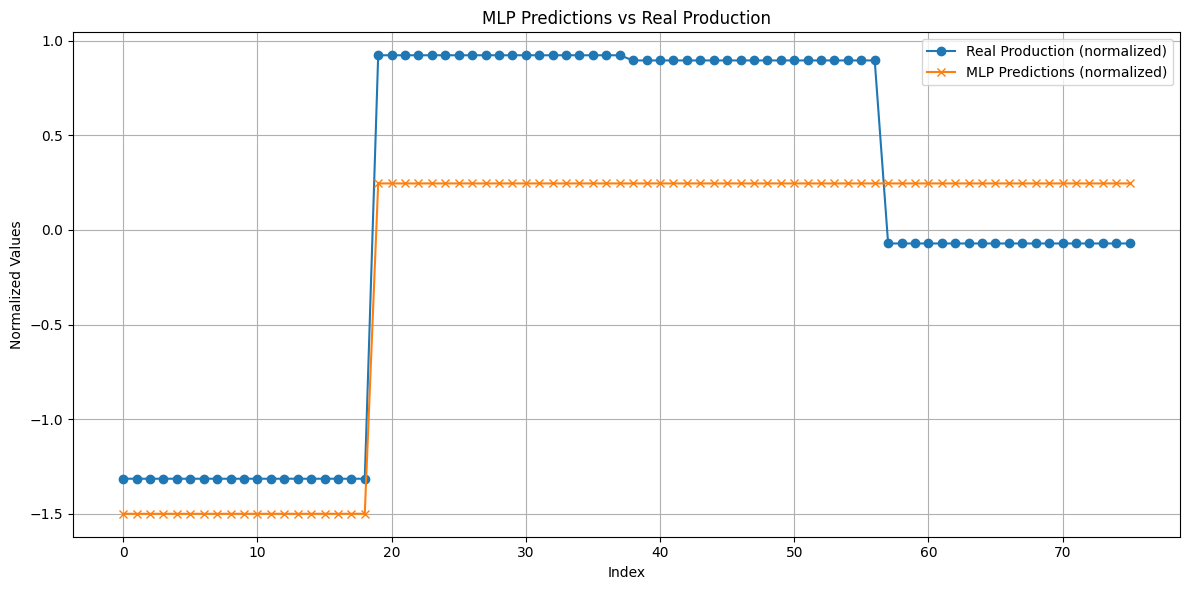

In [76]:
mlp_network.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in mlp_test_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = mlp_network(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0).flatten()
real_prods = np.concatenate(real_prods, axis=0).flatten()

# Print predictions and real productions
# print("LSTM Predictions for all test dataset:")
# print(all_preds)
# print("\nReal Production (normalized) for all test dataset:")
# print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker='o')
plt.plot(all_preds, label="MLP Predictions (normalized)", marker='x')
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("MLP Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

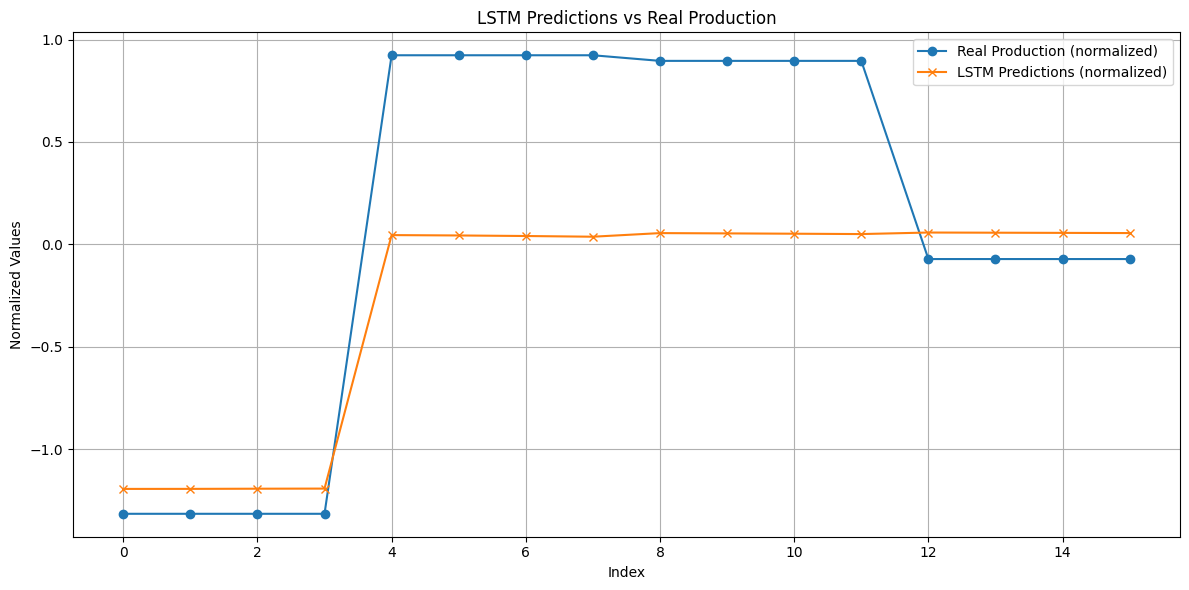

In [77]:
lstm_model.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in lstm_test_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = lstm_model(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0)
real_prods = np.concatenate(real_prods, axis=0)

# Print predictions and real productions
# print("LSTM Predictions for all test dataset:")
# print(all_preds)
# print("\nReal Production (normalized) for all test dataset:")
# print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker='o')
plt.plot(all_preds, label="LSTM Predictions (normalized)", marker='x')
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("LSTM Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
print("MLP test loss:", np.mean(test_losses_mlp))
for y_test in years_test:
    ndvi, prod = mlp_test_dataset_year_of_last.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = mlp_network(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    test_losses_mlp.append(last_pred)
    print(f"\n[MLP] Predicted (normalized) productivity for {y_test}: {last_pred:.4f}")
    print(f"[MLP] Real productivity (normalized) for {y_test}: {prod:.4f}")

print("\n\nLSTM test loss:", np.mean(test_losses_lstm))
for y_test in years_test:
    ndvi, prod = lstm_test_dataset_year_of_last.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = lstm_model(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    print(f"\n[LSTM] Predicted productivity (normalized) for {y_test}: {last_pred:.4f}")
    print(f"[LSTM] Real productivity (normalized) for {y_test}: {prod:.4f}")

MLP test loss: 0.25402429229334783

[MLP] Predicted (normalized) productivity for 2005: -1.5000
[MLP] Real productivity (normalized) for 2005: -1.3147

[MLP] Predicted (normalized) productivity for 2011: 0.2460
[MLP] Real productivity (normalized) for 2011: 0.9232

[MLP] Predicted (normalized) productivity for 2017: 0.2460
[MLP] Real productivity (normalized) for 2017: 0.8958

[MLP] Predicted (normalized) productivity for 2023: 0.2460
[MLP] Real productivity (normalized) for 2023: -0.0714


LSTM test loss: 0.379580011125654

[LSTM] Predicted productivity (normalized) for 2005: -1.1917
[LSTM] Real productivity (normalized) for 2005: -1.3147

[LSTM] Predicted productivity (normalized) for 2011: 0.0376
[LSTM] Real productivity (normalized) for 2011: 0.9232

[LSTM] Predicted productivity (normalized) for 2017: 0.0506
[LSTM] Real productivity (normalized) for 2017: 0.8958

[LSTM] Predicted productivity (normalized) for 2023: 0.0554
[LSTM] Real productivity (normalized) for 2023: -0.0714
